In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
#from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image
import pandas as pd
from skimage import io, transform, color
import os
import math
import torchvision.models as models
from imageio import imread
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
path = '../data/'
size = 193
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32

In [3]:
means = [0.49439774802337344,0.5177020917650417,0.5013496452715945]
stds = [0.16087996922691195,0.15714445907773483,0.1605951051365687]

In [109]:
figure_path = '../FinalReport/figures/classification/'

# load saved_model

In [4]:
model = torch.load('classification_checkpoint.pth')['model']

In [5]:
for param in model.parameters():
    param.requires_grad = False

# load_data

In [6]:
validation_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_validation_v2.csv')
validation_image_names = {2:validation_labels['image_name_2'],8:validation_labels['image_name_8'],5:validation_labels['image_name_5']}
validation_y = validation_labels['has_cell_13']

In [7]:
mean_sd_dict = {2: [0.49439774802337344, 0.16087996922691195],
 8: [0.5177020917650417, 0.15714445907773483],
 5: [0.5013496452715945, 0.1605951051365687],              }

In [8]:
def getXimage(maxrange):
    multiple_images = []
    for index in range(maxrange):
        #images = np.array()
        all_images_list = []
        for day,img_names in validation_image_names.items():
                #print(day, "   ", index)

            img_name = img_names[index]
            img_loc = os.path.join(path, img_name)
            image = io.imread(img_loc)
            mean, sd = mean_sd_dict[day]
            image = np.true_divide(color.rgb2gray(image) - mean, sd)
            image = color.rgb2gray(image)
            all_images_list.append(image)
        #images = np.array(all_images_list)
        images = np.stack(all_images_list, 0)
        #images = np.stack(all_images_list, 0).reshape((193,193,3))
        #print(images.shape[0])
        multiple_images.append(images)
    
    return torch.from_numpy(np.array(multiple_images)).float()
    #return images
def getY(maxrange):
    Y = validation_y[:maxrange]
    #return torch.from_numpy(np.asarray(validation_y[index]))
    #return Y
    return torch.LongTensor(Y)

In [83]:
X = getXimage(100)
y = getY(100)

In [84]:
X.shape

torch.Size([100, 3, 193, 193])

In [85]:
y.shape

torch.Size([100])

# Saliency Maps

In [86]:
model.eval()
X = X.to(device=device) 
y = y.to(device=device)
    # Make input tensor require gradient
X.requires_grad_()
    
saliency = None
N = y.shape[0]
scores = model(X)
correct_scores = scores.gather(1,y.view(-1,1)).squeeze()
correct_scores.backward(torch.ones(N).to(device=device))
saliency = X.grad.data.abs()
saliency,_=torch.max(saliency,dim=1)
saliency = saliency.squeeze()
saliency = saliency.cpu().numpy()

In [25]:
def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

In [116]:
def plot_saliency_map(index):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    image_name = validation_labels['image_name_2'][index]
    well_image = imread(path+image_name)
    imshow_no_ax(well_image, normalize=True)
    well_id = validation_labels['well_id'][index]
    condition = validation_labels['condition'][index]
    plt.axis('off')
    plt.title("well id: %d"%well_id)
    
    plt.subplot(2, 1, 2)
    plt.imshow(saliency[index], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
    plt.show()
    
    fig.savefig(figure_path+"well_%d_condition_%s_saliency_map.pdf"%(well_id,condition))

In [117]:
ran_index = random.randint(0,100)

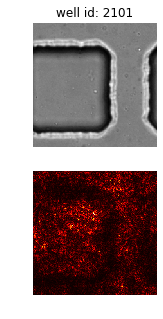

In [118]:
plot_saliency_map(26)

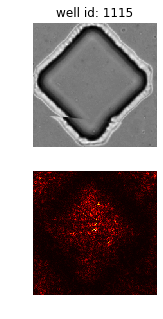

In [119]:
plot_saliency_map(89)

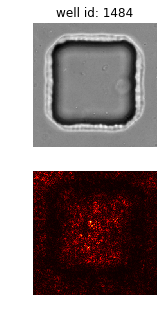

In [120]:
plot_saliency_map(86)

89


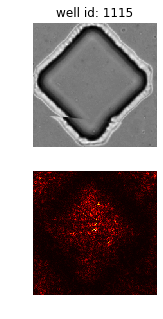

In [99]:
ran_index = random.randint(0,100)
print(ran_index)
plot_saliency_map(ran_index)

86


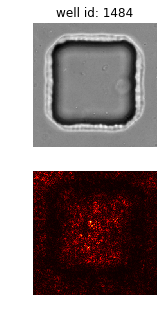

In [108]:
ran_index = random.randint(0,100)
print(ran_index)
plot_saliency_map(ran_index)

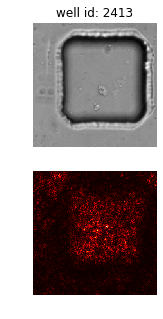

In [97]:
plot_saliency_map(1)

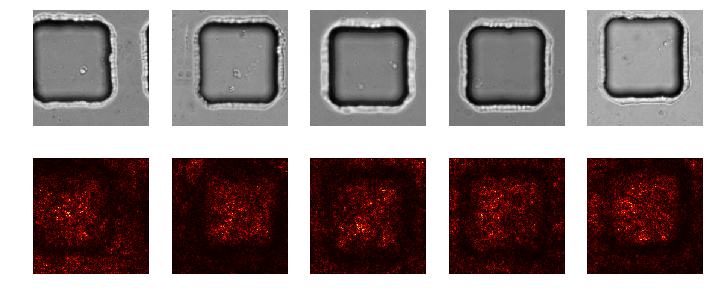

In [50]:
for i in range(N):
    plt.subplot(2, N, i + 1)
    image_name = validation_image_names[2][i]
    well_image = imread(path+image_name)
    imshow_no_ax(well_image, normalize=True)
    #plt.imshow(new_X[i].astype('uint8').reshape(193,193,3))
    plt.axis('off')
    #plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

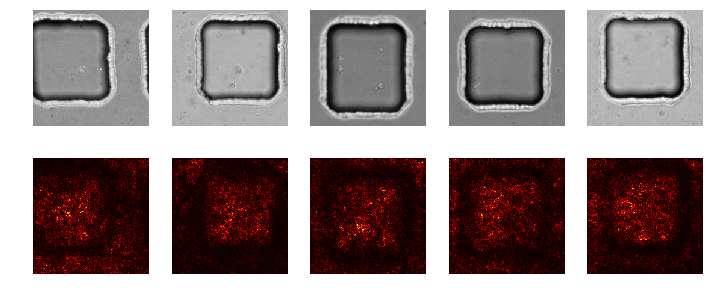

In [161]:
for i in range(N):
    plt.subplot(2, N, i + 1)
    image_name = validation_image_names[8][i]
    well_image = imread(path+image_name)
    imshow_no_ax(well_image, normalize=True)
    #plt.imshow(new_X[i].astype('uint8').reshape(193,193,3))
    plt.axis('off')
    #plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

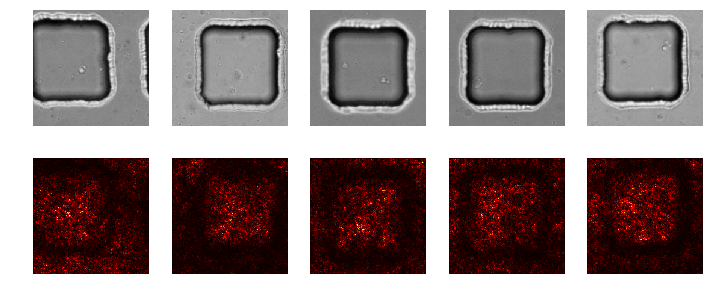

In [162]:
for i in range(N):
    plt.subplot(2, N, i + 1)
    image_name = validation_image_names[5][i]
    well_image = imread(path+image_name)
    imshow_no_ax(well_image, normalize=True)
    #plt.imshow(new_X[i].astype('uint8').reshape(193,193,3))
    plt.axis('off')
    #plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

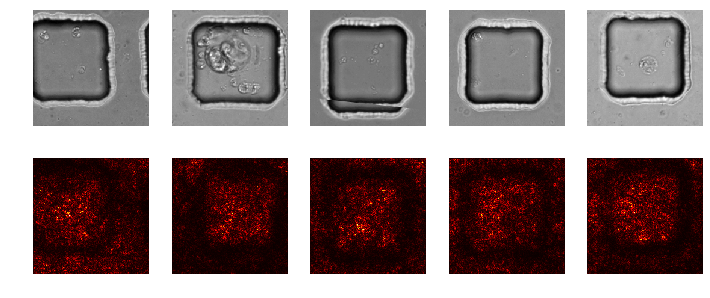

In [163]:
for i in range(N):
    plt.subplot(2, N, i + 1)
    image_name = validation_labels['image_name_13'][i]
    well_image = imread(path+image_name)
    imshow_no_ax(well_image, normalize=True)
    #plt.imshow(new_X[i].astype('uint8').reshape(193,193,3))
    plt.axis('off')
    #plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()